In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re, string
import nltk
import spacy

## Introduction

For this week's mini-project, we'll be completing the NLP with Disaster Tweets Project on Kaggle. In this data set there are tweets that at times have information on disasters that are occuring, and other times have harmless metaphors that use similar language. The example that they gave in the project brief is where a user wrote that the sky was "ablaze" during a sunset. For some models, this would suggest that the sky is literally on fire. Obviously, as humans we know that isn't the case, but in this week, we're trying to figure out if we can build a model that captures this use of language.

In [3]:
train = pd.read_csv("../input/nlp-getting-started/train.csv")
test = pd.read_csv("../input/nlp-getting-started/test.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# EDA

Now that the data sets have been loaded in, I'll look to explore the training set to see if the data is balanced, if any words need to be removed, and if there are any other cleaning steps that need to be done.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<AxesSubplot:>

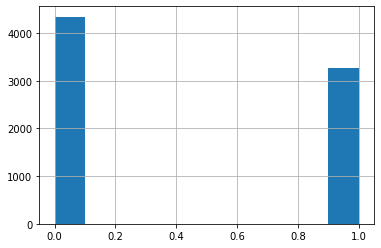

In [5]:
train['target'].hist()

Based on the training dataset, it looks like the data is indeed balanced in terms of those that are classified as disaster related or non-disaster related.

In [6]:
print(f"Training # of Tweets: {len(train)}")
print(f"Test # of Tweets: {len(test)}")
print(f"Total Tweets: {len(train) + len(test)}")

Training # of Tweets: 7613
Test # of Tweets: 3263
Total Tweets: 10876


In [7]:
import random
random_index = random.randint(0, len(train)-5)
print(train.iloc[random_index])
print(train['text'].iloc[random_index])

id                                                       1860
keyword                                                burned
location                                         Chicago Area
text        I joked about it but Wood has to be burned out...
target                                                      0
Name: 1288, dtype: object
I joked about it but Wood has to be burned out from working so many innings so often. #CubsTalk


From above, we see that we have a total of 10876 tweets to look at, with 7613 of them being in the training set. Looking at a random tweet, we can tell that there are certainly going to be stop words and punctuation. Before we create our models, we'll also need to tokenize the words in order to put the data into the model. In this case, I can utilize a tokenizer from tensor flow and standardize the data in that way, though I will go ahead and remove stop words now.

In [8]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

train['text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test['text'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

print(train.shape)
print(test.shape)

(7613, 5)
(3263, 4)


In [9]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds Reason #earthquake May ALLAH Forgive us,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked 'shelter place' notified o...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent photo Ruby #Alaska smoke #wildfi...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm top hill I see fire woods...,1
8,14,NaN,NaN,There's emergency evacuation happening buildin...,1
9,15,NaN,NaN,I'm afraid tornado coming area...,1


## Model Architecture
The way that I'm going to set up my model is to tokenize the data using the TextVectorization package from tensorflow, then feed that tokenized data into a GRU model, a variation on the LTSM. A GRU model, or Gated Recurrent Unit model, uses an update gate and a reset gate in order to decide which information is passed through to the output. GRU models are usually utilized in complex sentiment analysis, like this one. The main plus to GRU compared to the standard LTSM is the memory of the model, able to store things over time or ignore those features that are irrelevant to the output.

In [10]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train["text"].to_numpy(),train["target"].to_numpy(), random_state = 42)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(5709,)
(1904,)
(5709,)
(1904,)


In [11]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [12]:
textVectorizer = TextVectorization(max_tokens=5000,
                                    output_mode="int",
                                    output_sequence_length=20)
textVectorizer.adapt(X_train)

2022-12-04 01:00:56.086598: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-12-04 01:00:56.196251: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [13]:
vocab = textVectorizer.get_vocabulary()
top10 = vocab[:10]
print(top10)

['', '[UNK]', 'i', 'the', 'like', 'a', 'im', 'amp', 'fire', 'get']


From above, we can see that the top 10 words include "fire", "get", and "[UNK]". The last word "[UNK]" is the character used to describe any unknown word in the vocabulary. 

Now that the vectorizer has been set up, we need to set up layers for the GRU model.

In [14]:
from tensorflow.keras import layers
tf.random.set_seed(42)
#Building Layers
gruEmbedding = layers.Embedding(input_dim=5000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=20,
                                     name="embedding_gru")

inputs = layers.Input(shape=(1,), dtype="string")
x = textVectorizer(inputs)
x = gruEmbedding(x)
x = layers.GRU(64)(x) 
outputs = layers.Dense(1, activation="sigmoid")(x)
gruModel = tf.keras.Model(inputs, outputs, name="GRU_model")
#Compiling Model
gruModel.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [15]:
#Actually fitting the model
gruModelHist = gruModel.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
179/179 [==============================] - 9s 32ms/step - loss: 0.6199 - accuracy: 0.6388 - val_loss: 0.4724 - val_accuracy: 0.7931
Epoch 2/10
179/179 [==============================] - 5s 29ms/step - loss: 0.3865 - accuracy: 0.8380 - val_loss: 0.4377 - val_accuracy: 0.8083
Epoch 3/10
179/179 [==============================] - 5s 29ms/step - loss: 0.2896 - accuracy: 0.8900 - val_loss: 0.4754 - val_accuracy: 0.7952
Epoch 4/10
179/179 [==============================] - 6s 32ms/step - loss: 0.2305 - accuracy: 0.9157 - val_loss: 0.5569 - val_accuracy: 0.7799
Epoch 5/10
179/179 [==============================] - 5s 30ms/step - loss: 0.1878 - accuracy: 0.9357 - val_loss: 0.6303 - val_accuracy: 0.7710
Epoch 6/10
179/179 [==============================] - 5s 30ms/step - loss: 0.1509 - accuracy: 0.9483 - val_loss: 0.7855 - val_accuracy: 0.7505
Epoch 7/10
179/179 [==============================] - 5s 29ms/step - loss: 0.1140 - accuracy: 0.9595 - val_loss: 0.8064 - val_accuracy: 0.7558

In [16]:
#Helper function to create Validation/Training Plots via https://regenerativetoday.com/implementation-of-simplernn-gru-and-lstm-models-in-keras-and-tensorflow-for-an-nlp-project/
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


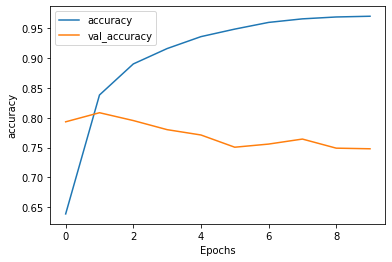

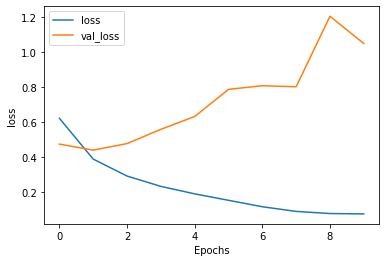

In [17]:
plot_graphs(gruModelHist, 'accuracy')
plot_graphs(gruModelHist, 'loss')

In [18]:
gruModelPredProbs = gruModel.predict(X_val)
gruModelPred = tf.squeeze(tf.round(gruModelPredProbs))
gruModelPred[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 0., 0., 1., 1., 1.], dtype=float32)>

In [19]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_val, gruModelPred)
print(acc)

0.7478991596638656


So, after the model has been created and ran, the overall accuracy was 76.1%. In the next section, I will tune hyper-parameters and look to find the best possible model for submission.

## Results and Analysis

In [20]:
tf.random.set_seed(42)

def hyperTest(input_dim, input_len):
    gruEmbedding = layers.Embedding(input_dim=input_dim,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=input_len,
                                     name="embedding_gru")

    inputs = layers.Input(shape=(1,), dtype="string")
    x = textVectorizer(inputs)
    x = gruEmbedding(x)
    x = layers.GRU(64)(x) 
    outputs = layers.Dense(1, activation="sigmoid")(x)
    name = "gruModel" +str(input_dim) +str(input_len)
    gruModel = tf.keras.Model(inputs, outputs, name = name)
    gruModel.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
    gruModelHist = gruModel.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
    gruModelPredProbs = gruModel.predict(X_val)
    gruModelPred = tf.squeeze(tf.round(gruModelPredProbs))
    return [input_dim, input_len, accuracy_score(y_val, gruModelPred)]



In [21]:
param_tuning = pd.DataFrame(columns = ['dim', 'len', 'acc'])
for dim in [5000,7500,10000]:
    for inLen in [5,15,25]:
        param_tuning.loc[len(param_tuning.index)] = hyperTest(dim, inLen)
param_tuning

Epoch 1/10
179/179 [==============================] - 9s 33ms/step - loss: 0.6199 - accuracy: 0.6388 - val_loss: 0.4724 - val_accuracy: 0.7931
Epoch 2/10
179/179 [==============================] - 5s 30ms/step - loss: 0.3865 - accuracy: 0.8380 - val_loss: 0.4377 - val_accuracy: 0.8083
Epoch 3/10
179/179 [==============================] - 5s 29ms/step - loss: 0.2896 - accuracy: 0.8900 - val_loss: 0.4754 - val_accuracy: 0.7952
Epoch 4/10
179/179 [==============================] - 5s 30ms/step - loss: 0.2305 - accuracy: 0.9157 - val_loss: 0.5569 - val_accuracy: 0.7799
Epoch 5/10
179/179 [==============================] - 5s 30ms/step - loss: 0.1878 - accuracy: 0.9357 - val_loss: 0.6303 - val_accuracy: 0.7710
Epoch 6/10
179/179 [==============================] - 6s 33ms/step - loss: 0.1509 - accuracy: 0.9483 - val_loss: 0.7855 - val_accuracy: 0.7505
Epoch 7/10
179/179 [==============================] - 5s 29ms/step - loss: 0.1140 - accuracy: 0.9595 - val_loss: 0.8064 - val_accuracy: 0.7558

,dim,len,acc
0,5000.0,5.0,0.747899
1,5000.0,15.0,0.748950
2,5000.0,25.0,0.752626
3,7500.0,5.0,0.755777
4,7500.0,15.0,0.747374
5,7500.0,25.0,0.756303
6,10000.0,5.0,0.746324
7,10000.0,15.0,0.756303
8,10000.0,25.0,0.759979


Overall the top model would be the GRU model with 10000 as the input dimensions and 5 as the input length. This model had an accuracy of 0.760. This model worked well because it had a smaller input length and a larger vocab, which allowed more granularity in the model itself.  I believe that adding or changing the architecture of the model itself may yield better results, but due to time constraints I will accept the model as is.

In [22]:
textVectorizer = TextVectorization(max_tokens=5000,
                                    output_mode="int",
                                    output_sequence_length=20)
textVectorizer.adapt(test['text'])

In [23]:
gruEmbedding = layers.Embedding(input_dim=10000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=5,
                                     name="embedding_gru")

inputs = layers.Input(shape=(1,), dtype="string")
x = textVectorizer(inputs)
x = gruEmbedding(x)
x = layers.GRU(64)(x) 
outputs = layers.Dense(1, activation="sigmoid")(x)
gruModel = tf.keras.Model(inputs, outputs, name = "final")
gruModel.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
gruModelHist = gruModel.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
179/179 [==============================] - 10s 40ms/step - loss: 0.6330 - accuracy: 0.6229 - val_loss: 0.4808 - val_accuracy: 0.7894
Epoch 2/10
179/179 [==============================] - 6s 34ms/step - loss: 0.4132 - accuracy: 0.8229 - val_loss: 0.4379 - val_accuracy: 0.8136
Epoch 3/10
179/179 [==============================] - 6s 35ms/step - loss: 0.3328 - accuracy: 0.8648 - val_loss: 0.4729 - val_accuracy: 0.8009
Epoch 4/10
179/179 [==============================] - 6s 35ms/step - loss: 0.2855 - accuracy: 0.8923 - val_loss: 0.5244 - val_accuracy: 0.7883
Epoch 5/10
179/179 [==============================] - 6s 35ms/step - loss: 0.2486 - accuracy: 0.9059 - val_loss: 0.5390 - val_accuracy: 0.7862
Epoch 6/10
179/179 [==============================] - 7s 37ms/step - loss: 0.2042 - accuracy: 0.9305 - val_loss: 0.5970 - val_accuracy: 0.7652
Epoch 7/10
179/179 [==============================] - 6s 35ms/step - loss: 0.1707 - accuracy: 0.9389 - val_loss: 0.6540 - val_accuracy: 0.774

In [24]:
# Preparation for model submission:
test_prop = gruModel.predict(test['text'])
test_pred = tf.squeeze(tf.round(test_prop))
test_pred = test_pred.numpy()
test_pred = test_pred.astype(int)

submiss = pd.DataFrame({"id": test ["id"], "target": test_pred})

submiss.to_csv('submission.csv', index=False)

## Conclusion

Based on the training and tuning, I was able to create a GRU model that had an accuracy of 0.760. Both my screenshot of the competition results as well as the github link in the submission file on Coursera. The main thing that hepled the performance of my models was changing the number of input dimensions, though admittedly all the models I tested were very close when it came to performance. In the future, changing the architecture of the model itself may have yielded improved results, as well as a more extensive gird search cross validation of the hyper-parameters. I also think that there is room to exclude certain other words in the corpus, as I probably didn't do enough cleaning for my first time doing a major NLP project.